# TME 4: Perceptron.

## HingeLoss

$ hinge(x) = max(0,-Y < \textbf{X,W}>) $

$ X \in \mathbb{R}^{nxm} $
$ Y \in \mathbb{R}^{nx1} $
$ W \in \mathbb{R}^{mx1} $

In [11]:
import arftools
import numpy as np
import matplotlib.pyplot as plt
import arftools

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def hinge_loss(X,Y,W):
    CW = -(Y*X.dot(W.T))
    Zeros = np.zeros(Y.shape)
    return np.maximum(Zeros,CW)
    
def hinge_loss_grad(X,Y,W):
    indicatrice = np.sign(hinge_loss(X,Y,W))
    NablaCW = indicatrice*-Y*X
    return NablaCW

class Perceptron(object):
    def __init__(self,loss,loss_g,max_iter=100,eps=0.1):
        self.max_iter, self.eps = max_iter,eps
        self.w = None
        self.loss = loss
        self.loss_g = loss_g
        self.kernel= None
        self.initialize_histo()
        
    def initialize_histo(self):
        self.w_histo = []
        self.loss_histo = []
        
    def initialize_w(self,D):
        self.w=np.random.random((1,D))
        
    def set_kernel(self,kernel):
        self.kernel=kernel
        
    def apply_kernel(self,datax,kernel='bias'):
        N = datax.shape[0] # Number of data points
        if kernel=='bias':
            homogeneus = np.ones((N,1))
            kernel_datax = datax.reshape(N,-1)
            kernel_datax = np.hstack((datax,homogeneus))
            return kernel_datax 
        return datax
            
    def fit_minibatch(self,datax,datay,batches=10,kernel=None):
        datay = datay.reshape(-1,1)
        N = len(datay) # Number of data points
        datax = datax.reshape(N,-1)
        datax = self.apply_kernel(datax,kernel=kernel)
        D = datax.shape[1] # dimension of data points
        self.initialize_w(D)
        self.initialize_histo()
        batch_size = N/batches
        for i in range(self.max_iter):
            self.w_histo += [self.w]
            batch_x = datax[(i%batches)*batch_size:((i%batches)+1)*batch_size]
            batch_y = datay[(i%batches)*batch_size:((i%batches)+1)*batch_size]
            CW = self.loss(batch_x,batch_y,self.w)
            loss = np.sum(CW)
            if loss <= 0.0001:
                break
            self.loss_histo += [loss]
            CW_grad = self.loss_g(batch_x,batch_y,self.w)
            collective_grad = np.sum(CW_grad,axis=0) # par ligne
            self.w -= collective_grad*self.eps
            
    def fit(self,datax,datay,kernel=None):
        if kernel == None:
            kernel = self.kernel
        self.fit_minibatch(datax,datay,batches=1,kernel=kernel)
            
    def predict(self,datax,kernel=None):
        if kernel == None:
            kernel = self.kernel
        N = datax.shape[0] # Number of data points
        datax = datax.reshape(N,-1)
        datax = self.apply_kernel(datax,kernel=kernel)
        return np.sign(datax.dot(self.w.T))
    
    def decision_function(self,datax):
        return self.predict(datax)
    
    def predict_proba(self,datax,kernel=None):
        return sigmoid(self.predict(datax))
    
    def predict_with_bias(self,datax):
        N = datax.shape[0] # Number of data points
        homogeneus = np.ones((N,1))
        datax = datax.reshape(N,-1)
        datax = np.hstack((datax,homogeneus))
        return np.sign(datax.dot(self.w.T))
    
    def score(self,datax,datay):
        return np.mean(self.predict(datax).T[0]==datay)
    
    def score_with_bias(self,datax,datay):
        N = datax.shape[0] # Number of data points
        homogeneus = np.ones((N,1))
        datax = datax.reshape(N,-1)
        datax = np.hstack((datax,homogeneus))
        return np.mean(self.predict(datax).T[0]==datay)


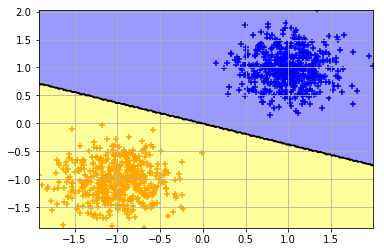

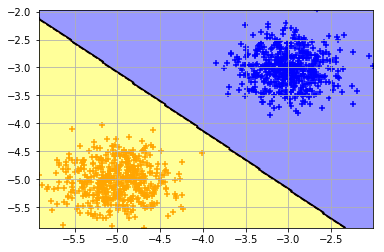

1.0


In [12]:

datax,datay = arftools.gen_arti()

my_perceptron = Perceptron(hinge_loss,hinge_loss_grad)
my_perceptron.fit(datax,datay)
arftools.fig_plot_frontiere(plt,datax,my_perceptron.predict)
arftools.fig_plot_data(plt,datax,datay)
plt.grid(True)
plt.show()


figure = plt.figure()
datax = datax-4
my_perceptron_bias = Perceptron(hinge_loss,hinge_loss_grad)
my_perceptron_bias.set_kernel('bias')
my_perceptron_bias.fit(datax,datay)
arftools.fig_plot_frontiere(plt,datax,my_perceptron_bias.predict)
arftools.fig_plot_data(plt,datax,datay)
plt.grid(True)
plt.show()

print my_perceptron_bias.score(datax,datay)



 # Train on the USPS dataset

In [13]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

def load_usps(fn):
    with open(fn,"r") as f:
        f.readline()
        data = [[float(x) for x in l.split()] for l in f if len(l.split())>2]
    tmp=np.array(data)
    return tmp[:,1:],tmp[:,0].astype(int)

def show_usps(data):
    """
    plot figure of digit
    """
    plt.imshow(data.reshape((16,16)),interpolation="nearest",cmap="gray")
    plt.show()

def char(character,datax,datay):
    """
    extract class
    """
    return datax[datay==character],datay[datay==character]


def plot_ROC(roc_curve_values, axe=plt,title='Receiver operating characteristic example'):
    fpr,tpr,roc_auc = roc_curve_values
    #axe.figure()
    axe.plot(fpr, tpr, color='darkorange', label='ROC curve (area = %0.2f)' % roc_auc)
    axe.plot([0, 1], [0, 1], color='navy', linestyle='--')
    axe.xlim([0.0, 1.0])
    axe.ylim([0.0, 1.05])
    axe.xlabel('False Positive Rate')
    axe.ylabel('True Positive Rate')
    axe.title(title)
    axe.legend(loc="lower right")

def compute_ROC(X,Y,clf):
    """
    Compute ROC of a trained classifier
    """
    y_score = clf.decision_function(X)
    y_score = label_binarize(y_score,classes=[0,1],  neg_label=-1, pos_label=1 )
    fpr,tpr,_ = roc_curve(Y, y_score)
    roc_auc = auc(fpr,tpr)
    return fpr,tpr,roc_auc
    

def usps_1vsMulti_class_train_and_test(trainx,trainy,testx,testy,clf,classes = 10):
    """
    Multiclass classification using 1 vs multi
    """
    print 'trainig'
    train_scores = np.zeros(classes)
    test_scores = np.zeros(classes)
    roc_curves = {}
    w_histo = []
    for i in range(classes):
        train_datax,train_datay = char(i,trainx,trainy)
        test_datax,test_datay = char(i,testx,testy)
        test_datay = np.ones(test_datay.shape)
        train_datay = np.ones(train_datay.shape)
        for j in range(classes):            
            if not i==j:
                ch1x,ch1y = char(j,trainx,trainy) 
                train_datax = np.vstack((train_datax,ch1x))
                train_datay = np.hstack((np.zeros(ch1y.shape)-1,train_datay))
                
                tch1x,tch1y = char(j,testx,testy)
                test_datax = np.vstack((test_datax,tch1x))
                test_datay = np.hstack((np.zeros(tch1y.shape)-1,test_datay))
        train_datay = label_binarize(train_datay, classes=[0,1],  neg_label=-1, pos_label=1 )
        test_datay = label_binarize(test_datay,classes=[0,1], neg_label=-1, pos_label=1 )
        clf.fit(train_datax,train_datay)
        train_scores[i] = clf.score(train_datax,train_datay)
        test_scores[i] = clf.score(test_datax,test_datay)
        roc_curves[i] = compute_ROC(test_datax,test_datay,clf)
        w_histo += [clf.w.copy()]
        
    return train_scores, test_scores, roc_curves, w_histo

import USPS_handler as USPS

fn_usps_train = 'USPS_train.txt'
fn_usps_test = 'USPS_test.txt'

trainx,trainy = USPS.load_usps(fn_usps_train)
testx,testy = USPS.load_usps(fn_usps_test)

clflin = Perceptron(hinge_loss,hinge_loss_grad)
train_scores_lin, test_scores_lin, roc_curves_lin, w_finals = usps_1vsMulti_class_train_and_test(trainx,trainy,testx,testy,clflin)


trainig


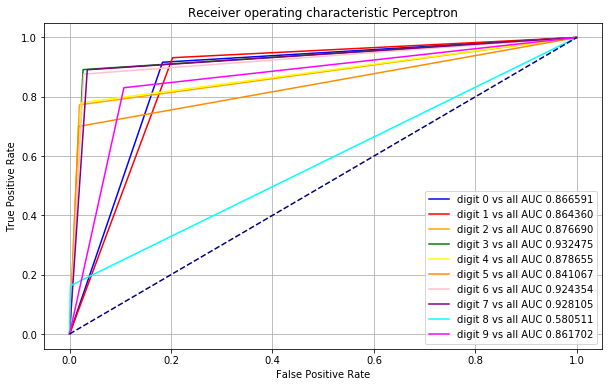

In [14]:
def plot_ROCS_multiclass(roc_curves_values,title='Receiver operating characteristic example'):
    labels = ['digit %d vs all AUC %f' % (i,roc_curves_values[i][2]) for i in range(len(roc_curves_values))]
    colors = ['blue','red','orange','green','yellow','darkorange','pink','purple','cyan','magenta']
    plot_ROCS(roc_curves_values,colors,labels,title=title)

def plot_ROCS(roc_curves_values,colors,labels,title='Receiver operating characteristic example'):
    plt.figure(0, figsize=(10, 6))
    plots = []
    for i in range(len(roc_curves_values)):
        fpr,tpr,roc_auc = roc_curves_values[i]
        plot, = plt.plot(fpr, tpr, color=colors[i], label=labels[i])
        plots += [plot]
    plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
    plt.legend(handles=plots)
    plt.grid(True)
    plt.title(title)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    
plot_ROCS_multiclass(roc_curves_lin, title='Receiver operating characteristic Perceptron')
plt.show()

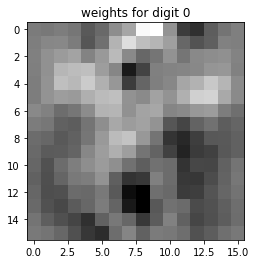

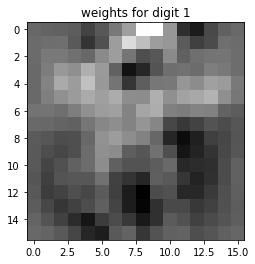

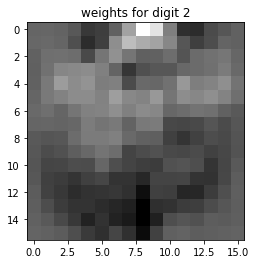

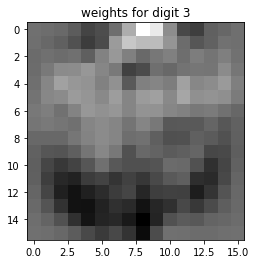

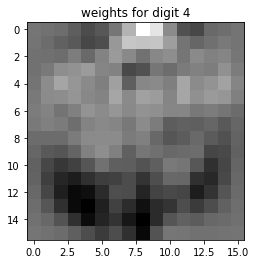

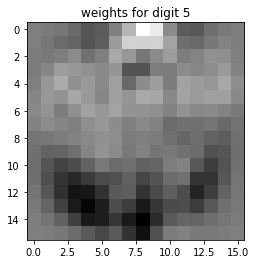

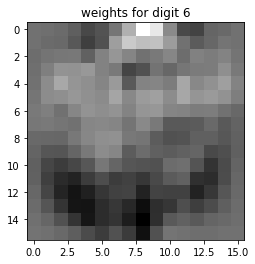

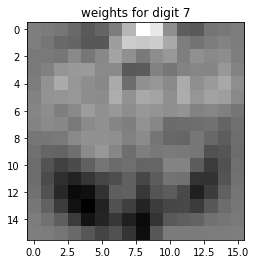

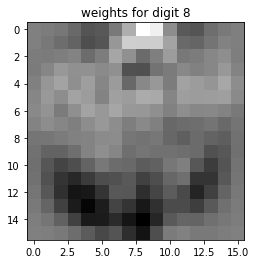

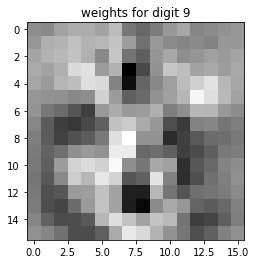

In [15]:
for i in range(10):
    plt.title('weights for digit %d' % i)
    USPS.show_usps(w_finals[i])


In [103]:
def gaussian_function(mu,sigma,K):
    def func(x):
        return K*np.exp(-(np.dot((mu-x).T,(mu-x)))/sigma)
    return func

def projection_gaussien(datax,sigma,K):
    D = datax.shape[0]
    projected_data = np.zeros((D,D))
    for i in range(D):
        projected_data[i,:] = np.array(map(gaussian_function(datax[i,:],sigma,K),datax))
    return projected_data

def projection_gaussien_grid(grid_space,datax,sigma,K):
    N = grid_space.shape[0]
    D = datax.shape[0]
    projected_data = np.zeros((N,D))
    for i in range(N):
        projected_data[i,:] = np.array(map(gaussian_function(grid_space[i,:],sigma,K),datax))
    return projected_data

datax,datay = arftools.gen_arti()
sigma = 1
K = 0.3
projected_data = projection_gaussien(datax,sigma,K)
grid_space,xx,yy = arftools.make_grid(datax)
projected_grid_space = projection_gaussien_grid(grid_space,datax,sigma,K)


1.0
400
400
400
(400L, 1L)


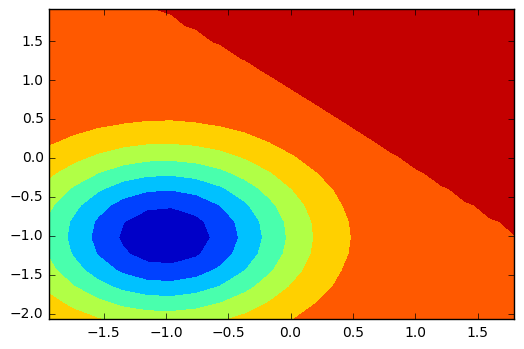

In [104]:
my_perceptron.fit(projected_data,datay)
print my_perceptron.score(projected_data,datay)
projected_grid_space_proba = my_perceptron.predict_proba(projected_grid_space)

print len(grid_space[:,0])
print len(grid_space[:,1])
print len(projected_grid_space_proba[:,0])
print projected_grid_space_proba.shape
plt.contourf(xx, yy, projected_grid_space_proba.reshape(yy.shape))
plt.show()

In [41]:
#1vsmany

fn_usps_train = 'USPS_train.txt'
fn_usps_test = 'USPS_test.txt'

trainx,trainy = load_usps(fn_usps_train)
testx,testy = load_usps(fn_usps_test)

my_perceptron = Perceptron(hinge_loss,hinge_loss_grad)
classes = 10
scores = np.zeros((classes,classes))
for i in range(classes):
    for j in range(classes):
        datax = None
        datay = None
        if not i==j:
            ch0x,ch0y = char(i,trainx,trainy)
            ch1x,ch1y = char(j,trainx,trainy) 
            datax = np.vstack((ch0x,ch1x))
            datay = np.hstack((np.zeros(ch1y.shape)-1,np.zeros(ch0y.shape)+1))
    
            my_perceptron.fit_with_bias(datax,datay)
            scores[i,j] = my_perceptron.score_with_bias(datax,datay)
print scores


SyntaxError: invalid syntax (<ipython-input-41-459dd6776870>, line 23)

In [120]:
def sigmoide(x):
    return 1/(1-np.exp(-x))

def soille(x,s): 
    return 1 if (x>s) else -1

w_0 = np.zeros((2,2)) +1
w_1 = np.array([1,-1])
s1 = 0.5
s2 = 1.5
s3 = 1

x_0 =  np.ones(2)
x_1 = w_0.dot(x_0.T)
x_1 = np.array([ soille(x_1[0],s1), soille(x_1[1],s2) ])
print x_1

x_2 = soille(w_1.dot(x_1.T),s3)

print x_2


[ 1.  1.]
[1 1]
-1
